# Diseño de software 

## Una integración con un API complejo: `matplotlib`

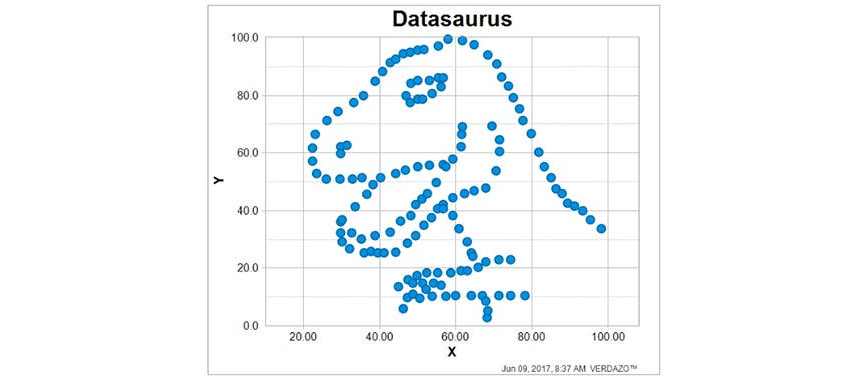

## Como se integra un plot

1. Hay que elegir el backend:
    - **matplotlib y derivados**.
    - bokeh
    - d3.
    - etc.
2. Elegir la forma del API:
    - funciones (a la seaborn)
    - OO (a la pandas)
        - Métodos
        - Accessors
3. Testing (Depende del backend)

## Arquitectura de gráficos en matplotlib

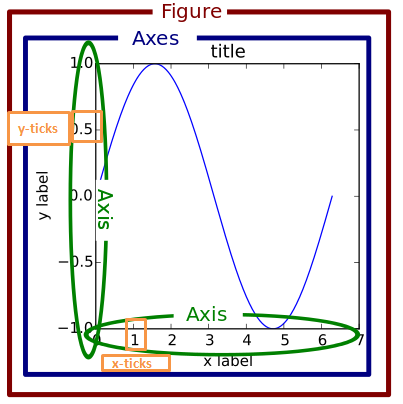

## Nuestra clase de ejemplo

In [1]:
import attr
import numpy as np

@attr.s
class Particle:
    x = attr.ib(converter=np.asarray)
    y = attr.ib(converter=np.asarray)
    z = attr.ib(converter=np.asarray)
    m = attr.ib(converter=np.asarray)
    
p = Particle(
    x = np.random.normal(size=100), 
    y = np.random.normal(size=100),
    z = np.random.normal(size=100),
    m = np.random.uniform(size=100)
)

## Un Plot simplón

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

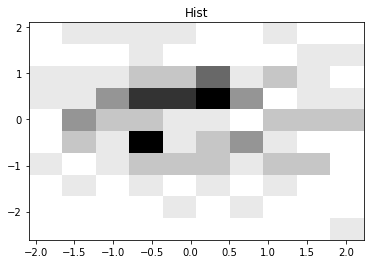

In [7]:
coso = plt.hist2d(p.x, p.y, cmap="Greys")
plt.title("Hist");

## 2 Plots simplones

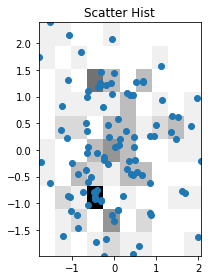

In [4]:
fig, ax = plt.subplots(figsize=(3, 4))

ax.hist2d(p.x, p.y, cmap="Greys")
ax.scatter(p.x, p.y)

ax.set_title("Scatter Hist")
fig.tight_layout()

## Functions

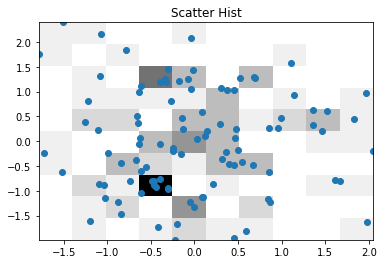

In [5]:
def scatter_hist(p, ax):
    
    ax.hist2d(p.x, p.y, cmap="Greys")
    ax.scatter(p.x, p.y)
    
    return ax

fig, ax = plt.subplots()
scatter_hist(p, ax)

ax.set_title("Scatter Hist");

## Functions Mejores

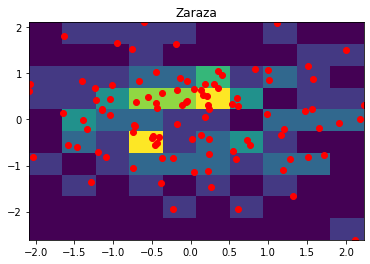

In [10]:
def scatter_hist(p, ax=None, hist_kws=None, scatter_kws=None):
    
    ax = plt.gca() if ax is None else ax
    
    hist_kws = {} if hist_kws is None else hist_kws
    scatter_kws = {} if scatter_kws is None else scatter_kws
    
    hist_kws.setdefault("cmap", "Greys")
    
    ax.hist2d(p.x, p.y, **hist_kws)
    ax.scatter(p.x, p.y, **scatter_kws)
    
    return ax

ax = scatter_hist(p, scatter_kws={"color": "r"}, hist_kws={"cmap": "viridis"})
ax.set_title("Zaraza");

## Pero ahora soporta multiple axis!

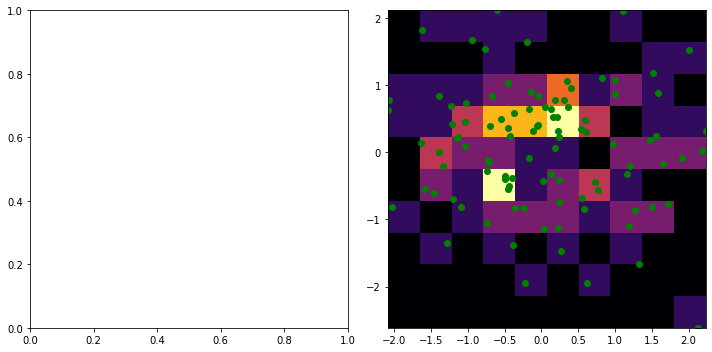

In [14]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

scatter_hist(p, ax=axs[1], hist_kws={"cmap": "inferno"}, 
             scatter_kws={"color": "g"})
fig.tight_layout()

## OOP

Ahora quiero lo mismo pero mezclándolo con estados

Algo asi:

```python
>>> p.plot(scatter_kws={"marker": "*", "s": 100, "color": "r"})
```

## Accessor

- En el contexto de [Pandas](https://towardsdatascience.com/pandas-dtype-specific-operations-accessors-c749bafb30a4)," un `accessor` se refiere a una propiedad que permite acceder a métodos y atributos específicos para un tipo de datos particular. 
- Un accessor común en pandas es el `.str`, que se utiliza para trabajar con datos de tipo cadena (strings) dentro de las Series o DataFrames. 
- El accessor `.plot` proporciona una forma conveniente de generar gráficos sin tener que importar bibliotecas adicionales como Matplotlib, especificando el tipo de gráfico y sus propiedades.
- Se pueden agregar a los dataframes [custom-accessors](https://pandas.pydata.org/docs/development/extending.html#registering-custom-accessors)



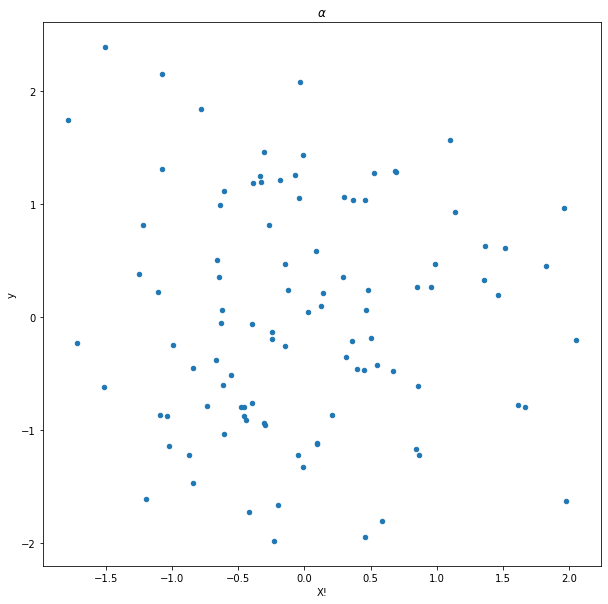

In [8]:
import pandas as pd

df = pd.DataFrame({"x": p.x, "y": p.y, "z": p.z, "m": p.m})
ax = df.plot.scatter(x="x", y="y",ax=plt.gca())

ax.set_title(r"$\alpha$")
ax.set_xlabel("X!")

fig = plt.gcf()
fig.set_size_inches(10, 10)

## Accessor

<AxesSubplot:>

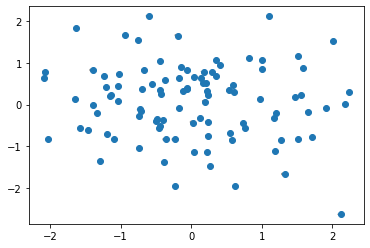

In [17]:
@attr.s(repr=False)
class ParticlePlotter:
    particle = attr.ib()
    def __repr__(self):
        return f"ParticlePlotter(particle={hex(id(self.particle))})"
    def __call__(self, kind="scatter_hist", **kwargs):
        method = getattr(self, kind)
        return method(**kwargs)
    
    def scatter_hexbin(self, ax=None, hexbin_kws=None, scatter_kws=None):
        p = self.particle
        ax = plt.gca() if ax is None else ax
        hexbin_kws = {} if hexbin_kws is None else hexbin_kws
        scatter_kws = {} if scatter_kws is None else scatter_kws
        hexbin_kws.setdefault("cmap", "Greys")
        ax.hexbin(p.x, p.y, **hexbin_kws)
        ax.scatter(p.x, p.y, **scatter_kws)
        return ax
    
    def scatter_hist(self, ax=None, hist_kws=None, scatter_kws=None):
        p = self.particle
        ax = plt.gca() if ax is None else ax
        hist_kws = {} if hist_kws is None else hist_kws
        scatter_kws = {} if scatter_kws is None else scatter_kws
        hist_kws.setdefault("cmap", "Greys")
        ax.hist2d(p.x, p.y, **hist_kws)
        ax.scatter(p.x, p.y, **scatter_kws)
        return ax
    
pp = ParticlePlotter(p)
pp("scatter_hexbin", hexbin_kws={"cmap": "viridis"})

In [28]:
@attr.s
class ParticleOOPAcc:
    x = attr.ib(converter=np.asarray)
    y = attr.ib(converter=np.asarray)
    z = attr.ib(converter=np.asarray)
    m = attr.ib(converter=np.asarray)
    
    @property
    def plot(self):
        if not hasattr(self, "_plot"):
            self._plot = ParticlePlotter(self)
        return self._plot
    
p = ParticleOOPAcc(
    x = np.random.normal(size=100), 
    y = np.random.normal(size=100),
    z = np.random.normal(size=100),
    m = np.random.uniform(size=100)
)
id(p.plot)

140004948355072

## Testing

- El testing de plots se lleva adelante utilizando las facilidades del engine subjacente.
- Matplotlib ofrece una serie de decoradores útiles para comparar dos imágnes píxel a píxel.
- En particular nos interesa `from matplotlib.testing.decorators import check_figures_equal`.

**El decorador lo que hace es:**

0. Por defecto ejecuta el test 3 veces para los formatos `png`, `pdf` y `svg`.
1. inyecta dos figuras como fixtures al test:
   
   - `fig_test` figura donde debe dibujarse la implementación a testear.
   - `fig_ref` Esta es donde hay que dibujar tiene el resultado esperado.
   
2. El decorador escribe las dos figuras a disco en una carpeta *result_images* (al `.gitignore`).
3. Compara las imágenes pixel a pixel y de ser distintas el test falla y crea una imagen de diferencia en formato `png` en el mismo directorio.

## Testing

Matplotlib ofrece su propia librería de testing dentro de `matplotlib.testing`

In [11]:
from matplotlib.testing.decorators import check_figures_equal

@check_figures_equal(extensions=["png"])
def test_ParticleOOP_scatterhist(fig_test, fig_ref):
    p = ParticleOOPAcc(
        x = np.random.normal(size=100), 
        y = np.random.normal(size=100),
        z = np.random.normal(size=100),
        m = np.random.uniform(size=100)
    )
    
    # test
    test_ax = fig_test.subplots()
    p.plot.scatter_hist(ax=test_ax)
    
    #expected
    exp_ax = fig_ref.subplots()
  
    exp_ax.hist2d(p.x, p.y, cmap="Greys")
    exp_ax.scatter(p.x, p.y)    


In [15]:
!batcat 01_plot_api_integration/test_particle_plot.py --theme GitHub -p

import attr

import numpy as np

import matplotlib.pyplot as plt


@attr.s(repr=False)
class ParticlePlotter:
    particle = attr.ib()
    
    def __repr__(self):
        return f"ParticlePlotter(particle={hex(id(self.particle))})"
    
    def __call__(self, kind="scatter_hist", **kwargs):
        method = getattr(self, kind)
        return method(**kwargs)
    
    def scatter_hexbin(self, ax=None, hexbin_kws=None, scatter_kws=None):
        
        p = self.particle
        
        ax = plt.gca() if ax is None else ax

        hexbin_kws = {} if hexbin_kws is None else hexbin_kws
        scatter_kws = {} if scatter_kws is None else scatter_kws

        hexbin_kws.setdefault("cmap", "Greys")

        ax.hexbin(p.x, p.y, **hexbin_kws)
        ax.scatter(p.x, p.y, **scatter_kws)

        return ax
    
    def scatter_hist(self, ax=None, hist_kws=None, scatter_kws=None):
        p = self.particle
        ax = plt.gca() if ax is None else ax
        hist_kws = {} if hist_kws is None 

## Testing

El test esta hecho para que falle aproposito asi vemos las capacidades de la libreria

In [16]:
!pytest 01_plot_api_integration/test_particle_plot.py -v

============================= test session starts ==============================
platform linux -- Python 3.10.12, pytest-7.1.3, pluggy-1.0.0 -- /home/juanbc/proyectos/dis_ssw/bin/python
cachedir: .pytest_cache
hypothesis profile 'default' -> database=DirectoryBasedExampleDatabase('/home/juanbc/proyectos/dis_ssw/src/03_DIS/.hypothesis/examples')
rootdir: /home/juanbc/proyectos/dis_ssw/src/03_DIS
plugins: cov-4.1.0, hypothesis-6.54.5, anyio-3.6.1
collected 3 items                                                              

01_plot_api_integration/test_particle_plot.py::test_ParticleOOP_scatterhist[png] FAILED [ 33%]
01_plot_api_integration/test_particle_plot.py::test_ParticleOOP_scatterhist[pdf] FAILED [ 66%]
01_plot_api_integration/test_particle_plot.py::test_ParticleOOP_scatterhist[svg] FAILED [100%]

=================================== FAILURES ===================================
______________________ test_ParticleOOP_scatterhist[png] _______________________

ext = 'png'
request 